In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import densenet121
from PIL import Image

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".png"):
                    full_path = os.path.join(root, file)
                    label = 1 if "positive" in root.lower() else 0
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/train", transform=transform)
valid_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/valid", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

print(f"Train imgs: {len(train_dataset)} | Valid imgs: {len(valid_dataset)}")

Train imgs: 12 | Valid imgs: 11


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3

In [5]:
densenet = densenet121(weights="DEFAULT")
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
densenet = densenet.to(DEVICE)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/alvarosanchez/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 19.7MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    densenet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validación
    densenet.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = densenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(densenet.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/densenet121_binario.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 0.7119 | Val Loss: 0.6929 | Acc: 0.5455 | F1: 0.7059
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.2423 | Val Loss: 0.6072 | Acc: 0.6364 | F1: 0.7500
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.0965 | Val Loss: 0.5564 | Acc: 0.6364 | F1: 0.7500
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.0506 | Val Loss: 0.5153 | Acc: 0.7273 | F1: 0.8000
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.0316 | Val Loss: 0.4884 | Acc: 0.9091 | F1: 0.9231
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.0219 | Val Loss: 0.4712 | Acc: 0.9091 | F1: 0.9231
Mejor modelo guardado.
Epoch 7 | Train Loss: 0.0163 | Val Loss: 0.4575 | Acc: 0.8182 | F1: 0.8333
Mejor modelo guardado.
Epoch 8 | Train Loss: 0.0127 | Val Loss: 0.4489 | Acc: 0.9091 | F1: 0.9091
Mejor modelo guardado.
Epoch 9 | Train Loss: 0.0103 | Val Loss: 0.4432 | Acc: 0.9091 | F1: 0.9091
Mejor modelo guardado.
Epoch 10 | Train Loss: 0.0085 | Val Loss: 0.4423 | Acc: 0.9091 | F1: 0.9091
Mejor modelo guardado.



 Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       0.83      1.00      0.91         5
    positive       1.00      0.83      0.91         6

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



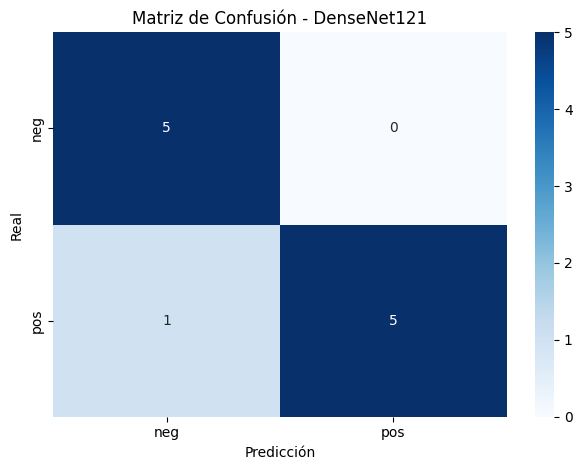

In [7]:
print("\n Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Matriz de Confusión - DenseNet121")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()